### Importing packages

In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
import numpy as np

### Importing files

In [2]:
# Mounting Google Drive
drive.mount('/content/drive')

# Loading and Unzipping files
file_path = '/content/drive/My Drive/widsdatathon2024-challenge2.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

Mounted at /content/drive


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,...,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,...,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
2,277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,...,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
3,320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
4,190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,...,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286


# EDA

# Heatmap of correlation between features and target variable

In [3]:
# Correlations between numerical columns and 'metastatic_cancer' column
numerical_columns = train.select_dtypes(include=['int', 'float']).columns
correlation_with_metastatic_cancer = train[numerical_columns].corrwith(train['metastatic_diagnosis_period'])

In [4]:
sorted_correlation = correlation_with_metastatic_cancer.abs().sort_values(ascending=False)
sorted_correlation

metastatic_diagnosis_period    1.000000
patient_age                    0.055231
labor_force_participation      0.039369
family_dual_income             0.036403
education_bachelors            0.033842
                                 ...   
Average of Apr-14              0.000391
veteran                        0.000365
Average of Mar-16              0.000292
rent_burden                    0.000201
home_ownership                 0.000192
Length: 141, dtype: float64

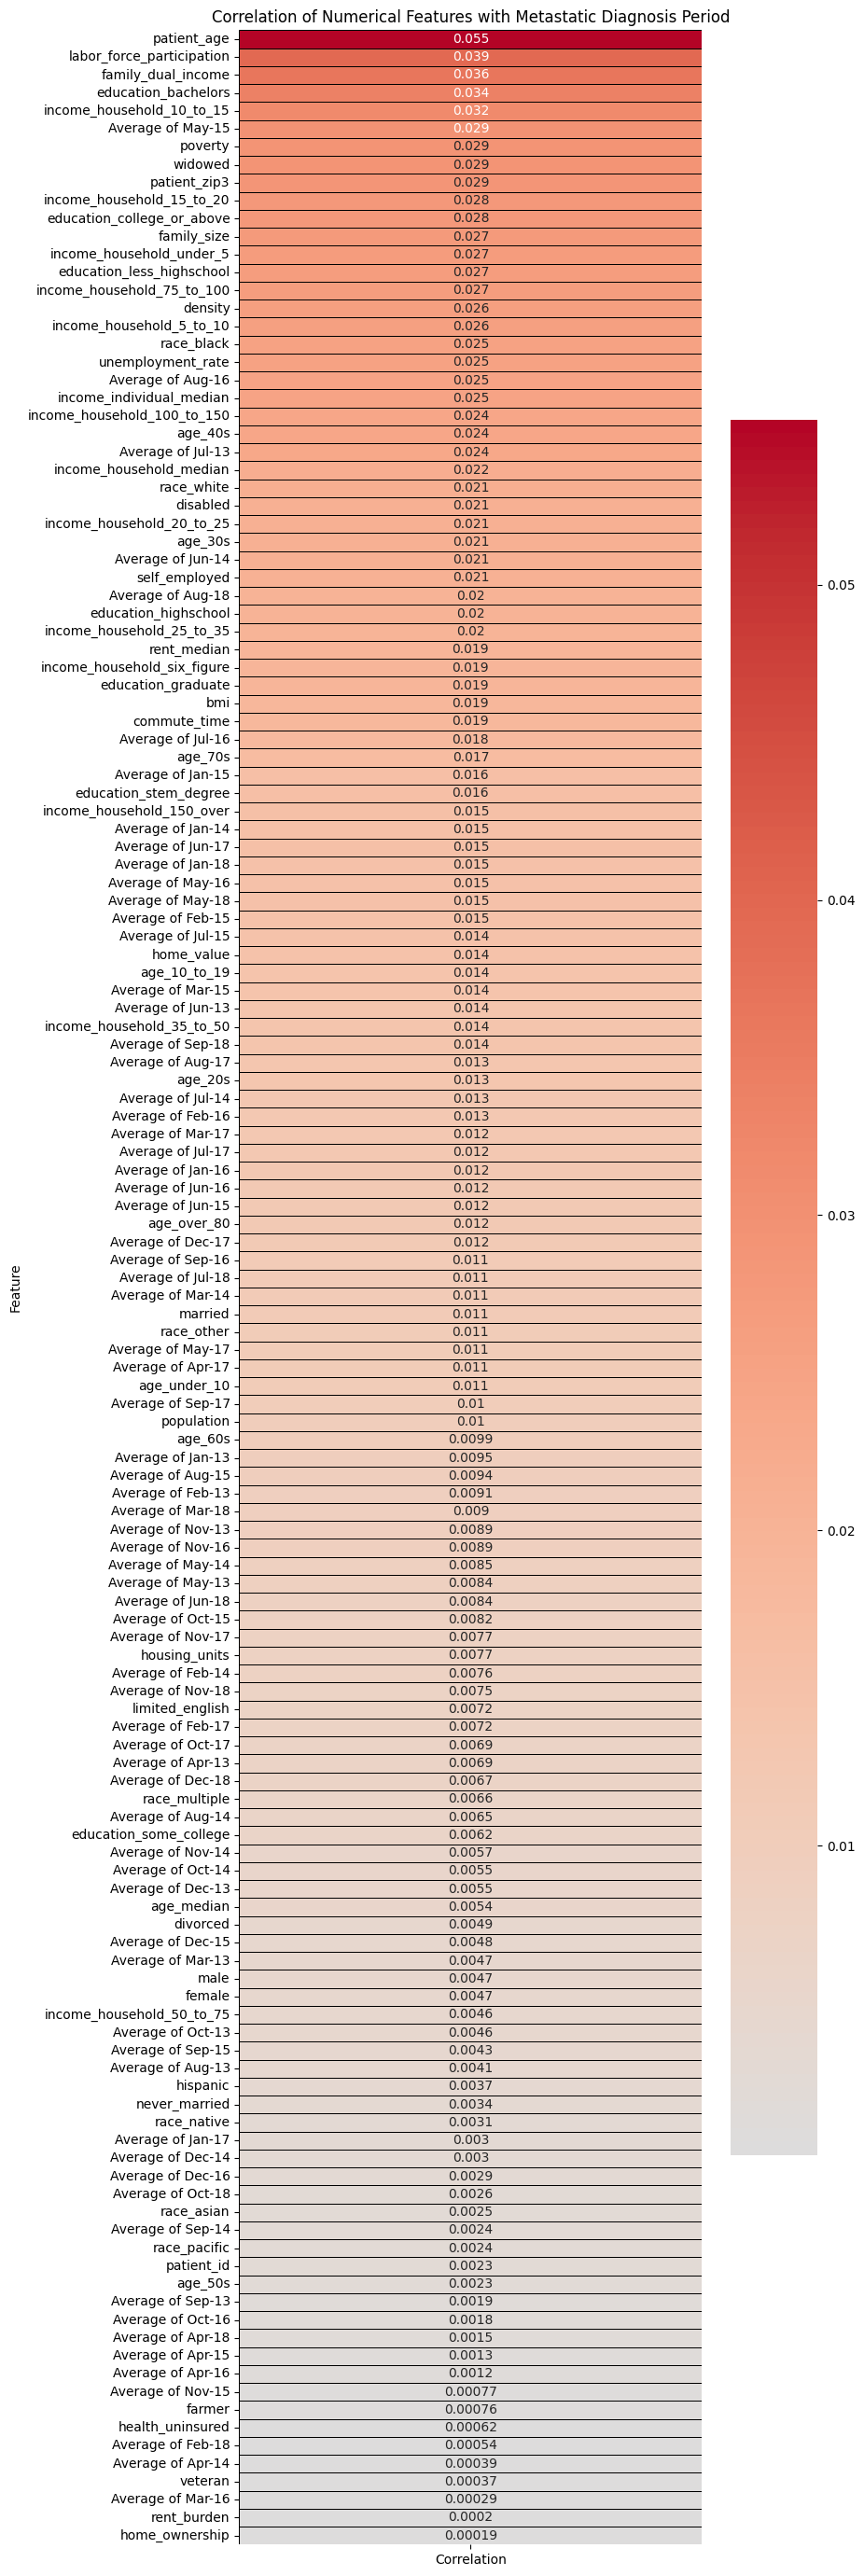

In [5]:
# Calculate correlations between numerical columns and 'metastatic_diagnosis_period' column
numerical_columns = train.select_dtypes(include=['int', 'float']).columns
correlation_with_metastatic_cancer = train[numerical_columns].corrwith(train['metastatic_diagnosis_period'])

# Take the absolute value of correlations and sort them in descending order
correlation_with_metastatic_cancer = correlation_with_metastatic_cancer.abs().sort_values(ascending=False)

# Convert the correlation series to a DataFrame
correlation_df = correlation_with_metastatic_cancer.to_frame().reset_index()
correlation_df.columns = ['Feature', 'Correlation']
correlation_df = correlation_df[correlation_df['Feature'] != 'metastatic_diagnosis_period']

# Set the feature names as index
correlation_df.set_index('Feature', inplace=True)

# Heatmap
plt.figure(figsize=(8,35))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')
plt.title('Correlation of Numerical Features with Metastatic Diagnosis Period')
plt.show()

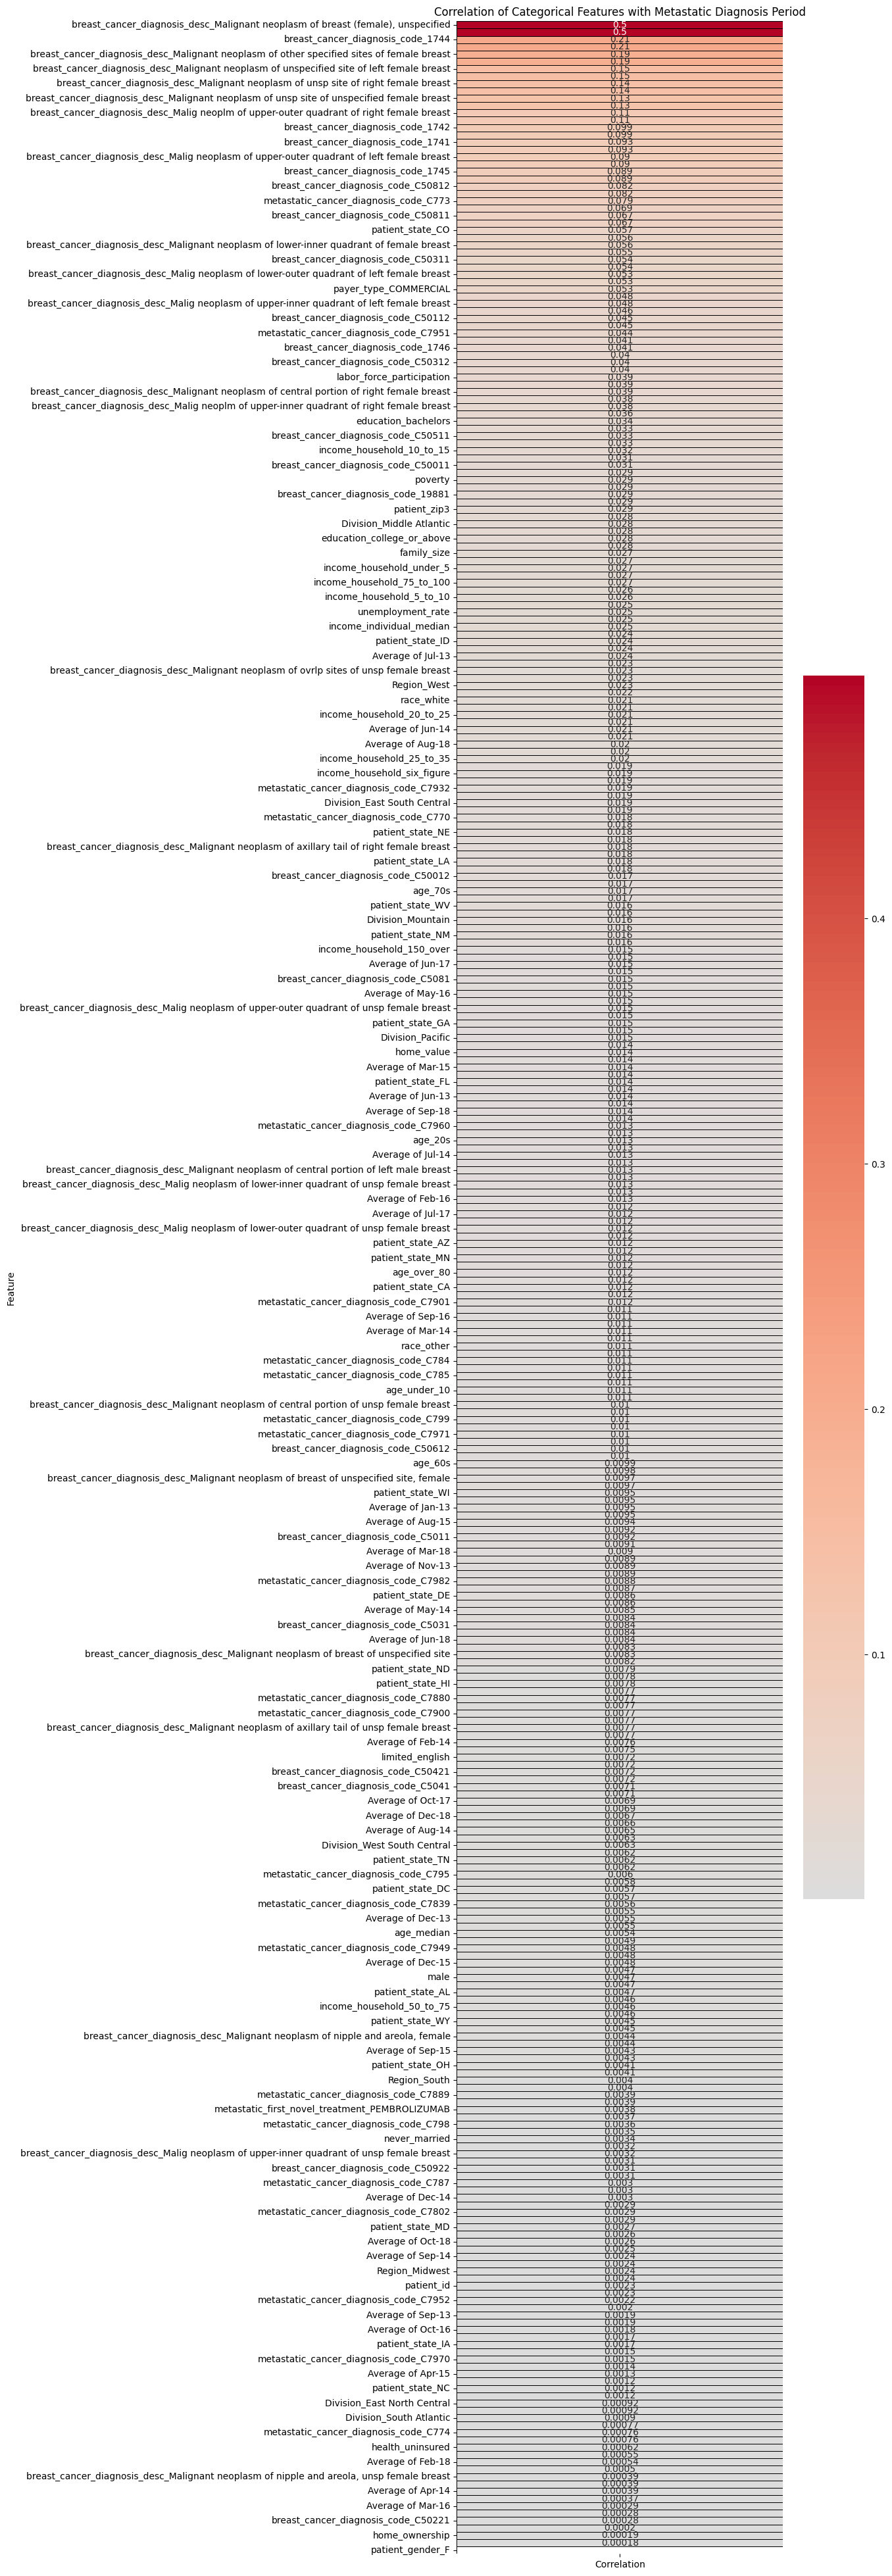

In [6]:
# Select columns with object data type
categorical_columns = train.select_dtypes(exclude=['int', 'float']).columns.tolist()

# One-hot encode categorical features
one_hot_encoded = pd.get_dummies(train[categorical_columns])

# Concatenate one-hot encoded features with numerical features
all_features = pd.concat([one_hot_encoded, train[numerical_columns]], axis=1)

# Calculate correlations between all features and 'metastatic_diagnosis_period' column
correlation_with_metastatic_cancer = all_features.corrwith(train['metastatic_diagnosis_period'])

# Take the absolute value of correlations and sort them in descending order
correlation_with_metastatic_cancer = correlation_with_metastatic_cancer.abs().sort_values(ascending=False)

# Convert the correlation series to a DataFrame
correlation_df = correlation_with_metastatic_cancer.to_frame().reset_index()
correlation_df.columns = ['Feature', 'Correlation']
correlation_df = correlation_df[correlation_df['Feature'] != 'metastatic_diagnosis_period']

# Set the feature names as index
correlation_df.set_index('Feature', inplace=True)

# Heatmap
plt.figure(figsize=(8, 50))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')
plt.title('Correlation of Categorical Features with Metastatic Diagnosis Period')
plt.show()

# Feature engineering to produce a Average Temp & Winter/Summer Averages

By condensing monthly average temperatures into a yearly average & summer/winter temperature, we simplify the dataset while retaining the essential information. This simplification is beneficial for predictive modeling, such as predicting metastasis, because it reduces the dimensionality of the data without losing significant predictive power.

# Average temperature

In [7]:
# Define the regex pattern
pattern = re.compile('^Average of')

# Filter columns based on the regex pattern using list comprehension
ave_temp_cols = [col for col in train.columns if pattern.match(col)]

# Create a new DataFrame containing only the matched columns
ave_temp_df = train.loc[:, ave_temp_cols]

# Print the matched DataFrame
ave_temp_df

# Producing a Yearly Average
ave_temp_df['Average_temp']= ave_temp_df.mean(axis=1)
ave_temp_df

Average_year_temp = ave_temp_df[['Average_temp']]

# Average Winter temperature

In [8]:
# Define the regex patterns
pattern_dec = re.compile('^Average of Dec')
pattern_jan = re.compile('^Average of Jan')
pattern_feb = re.compile('^Average of Feb')

# Filter columns based on the regex patterns and combine the results
pattern_match = [col for col in train.columns if pattern_dec.match(col)]
pattern_match += [col for col in train.columns if pattern_jan.match(col)]
pattern_match += [col for col in train.columns if pattern_feb.match(col)]

# Create a new DataFrame containing only the matched columns
winter_temp_df = train.loc[:, pattern_match]

# Calculate the yearly average temperature
winter_temp_df = winter_temp_df.mean(axis=1)

# Update the 'Winter_temp' column in the existing DataFrame
Average_year_temp['Winter_temp'] = winter_temp_df

<ipython-input-8-03612ec955ee>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Winter_temp'] = winter_temp_df


# Average Spring temperature

In [9]:
# Define the regex patterns
pattern_march = re.compile('^Average of Mar')
pattern_april = re.compile('^Average of Apr')
pattern_may = re.compile('^Average of May')

# Filter columns based on the regex patterns and combine the results
pattern_match = [col for col in train.columns if pattern_march.match(col)]
pattern_match += [col for col in train.columns if pattern_april.match(col)]
pattern_match += [col for col in train.columns if pattern_may.match(col)]

# Create a new DataFrame containing only the matched columns
spring_temp_df = train.loc[:, pattern_match]

# Calculate the yearly average temperature
spring_temp_df = spring_temp_df.mean(axis=1)

# Update the 'Winter_temp' column in the existing DataFrame
Average_year_temp['Spring_temp'] = spring_temp_df

<ipython-input-9-1eb7f06f7cdd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Spring_temp'] = spring_temp_df


# Average Summer Temperature

In [10]:
# Define the regex patterns for June, July, and August
pattern_june = re.compile('^Average of Jun')
pattern_july = re.compile('^Average of Jul')
pattern_august = re.compile('^Average of Aug')

# Filter columns based on the regex patterns and combine the results
pattern_match = [col for col in train.columns if pattern_june.match(col)]
pattern_match += [col for col in train.columns if pattern_july.match(col)]
pattern_match += [col for col in train.columns if pattern_august.match(col)]

# Create a new DataFrame containing only the matched columns
summer_temp_df = train.loc[:, pattern_match]

# Calculate the yearly average temperature
summer_temp_df = summer_temp_df.mean(axis=1)

# Update the 'Summer_temp' column in the existing DataFrame
Average_year_temp['Summer_temp'] = summer_temp_df

<ipython-input-10-a67c66c10f79>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Summer_temp'] = summer_temp_df


# Average Autumn temperature

In [11]:
# Define the regex patterns for September, October, and November
pattern_september = re.compile('^Average of Sep')
pattern_october = re.compile('^Average of Oct')
pattern_november = re.compile('^Average of Nov')

# Filter columns based on the regex patterns and combine the results
pattern_match = [col for col in train.columns if pattern_september.match(col)]
pattern_match += [col for col in train.columns if pattern_october.match(col)]
pattern_match += [col for col in train.columns if pattern_november.match(col)]

# Create a new DataFrame containing only the matched columns
autumn_temp_df = train.loc[:, pattern_match]

# Calculate the yearly average temperature
autumn_temp_df = autumn_temp_df.mean(axis=1)

# Update the 'Autumn_temp' column in the existing DataFrame
Average_year_temp['Autumn_temp'] = autumn_temp_df

# Print the updated DataFrame with yearly average temperature
Average_year_temp

<ipython-input-11-08e81f67829d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Autumn_temp'] = autumn_temp_df


,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp
0,59.083750,38.928889,58.129444,78.365556,60.911111
1,56.399028,35.376111,55.996667,76.002222,58.221111
2,70.011250,57.466667,67.862778,82.916667,71.798889
3,66.694861,60.693333,63.912222,71.974444,70.199444
4,61.847361,54.418889,60.406667,68.240556,64.323333
...,...,...,...,...,...
13168,54.405694,35.226111,51.873333,74.336667,56.186667
13169,66.802083,50.260556,66.135000,82.684444,68.128333
13170,68.743750,60.765556,66.255556,76.016111,71.937778
13171,48.475694,25.986111,46.163889,69.866111,51.886667


In [12]:
# Adding average yearly temp with other features that I believe are good predcitors
Train = Average_year_temp

Train = pd.merge(Train, train[['metastatic_diagnosis_period','patient_age','bmi','patient_race','patient_state','patient_zip3' ,'Region', 'Division','breast_cancer_diagnosis_code','metastatic_cancer_diagnosis_code', 'income_household_median',
                               'payer_type','health_uninsured','density','farmer','home_ownership','education_college_or_above','family_dual_income','family_size', 'education_bachelors','labor_force_participation','widowed', 'poverty' ]],
                        left_index=True, right_index=True, how='left')

In [13]:
Train.head()

,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp,metastatic_diagnosis_period,patient_age,bmi,patient_race,patient_state,...,density,farmer,home_ownership,education_college_or_above,family_dual_income,family_size,education_bachelors,labor_force_participation,widowed,poverty
0,59.083750,38.928889,58.129444,78.365556,60.911111,191,39,NaN,NaN,AR,...,82.63,5.31,72.11,13.32,43.99,3.01,9.21,53.60,8.66,19.27
1,56.399028,35.376111,55.996667,76.002222,58.221111,33,55,35.36,White,IL,...,51.79,5.21,76.71,18.49,41.41,3.17,12.46,52.51,8.17,16.94
2,70.011250,57.466667,67.862778,82.916667,71.798889,157,59,NaN,NaN,CA,...,700.34,0.44,66.82,22.32,52.89,3.80,13.92,59.47,4.95,12.72
3,66.694861,60.693333,63.912222,71.974444,70.199444,146,59,NaN,Hispanic,CA,...,5294.33,0.01,31.50,37.58,55.53,3.44,23.89,64.39,4.77,20.76
4,61.847361,54.418889,60.406667,68.240556,64.323333,286,71,NaN,NaN,CA,...,400.48,1.46,58.81,31.14,51.88,3.09,19.14,55.20,5.01,10.34


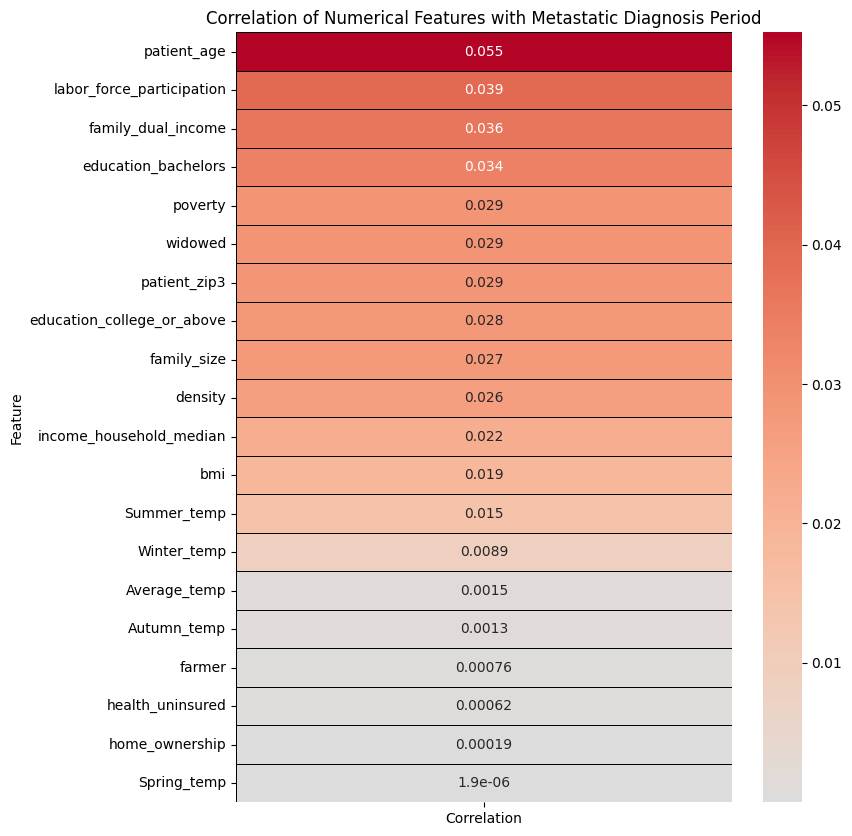

In [14]:
# Calculate correlations between numerical columns and 'metastatic_diagnosis_period' column
numerical_columns = Train.select_dtypes(include=['int', 'float']).columns
correlation_with_metastatic_cancer = Train[numerical_columns].corrwith(Train['metastatic_diagnosis_period'])

# Take the absolute value of correlations and sort them in descending order
correlation_with_metastatic_cancer = correlation_with_metastatic_cancer.abs().sort_values(ascending=False)

# Convert the correlation series to a DataFrame
correlation_df = correlation_with_metastatic_cancer.to_frame().reset_index()
correlation_df.columns = ['Feature', 'Correlation']
correlation_df = correlation_df[correlation_df['Feature'] != 'metastatic_diagnosis_period']

# Set the feature names as index
correlation_df.set_index('Feature', inplace=True)

# Heatmap
plt.figure(figsize=(8,10))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')
plt.title('Correlation of Numerical Features with Metastatic Diagnosis Period')
plt.show()

## Feature Engineering for Test set

In [15]:
# Define the regex pattern
pattern = re.compile('^Average of')

# Filter columns based on the regex pattern using list comprehension
ave_temp_cols = [col for col in test.columns if pattern.match(col)]

# Create a new DataFrame containing only the matched columns
ave_temp_df = test.loc[:, ave_temp_cols]

# Print the matched DataFrame
ave_temp_df

# Producing a Yearly Average
ave_temp_df['Average_temp'] = ave_temp_df.mean(axis=1)
ave_temp_df

Average_year_temp = ave_temp_df[['Average_temp']]

# Define the regex patterns
pattern_dec = re.compile('^Average of Dec')
pattern_jan = re.compile('^Average of Jan')
pattern_feb = re.compile('^Average of Feb')

# Filter columns based on the regex patterns and combine the results
pattern_match = [col for col in test.columns if pattern_dec.match(col)]
pattern_match += [col for col in test.columns if pattern_jan.match(col)]
pattern_match += [col for col in test.columns if pattern_feb.match(col)]

# Create a new DataFrame containing only the matched columns
winter_temp_df = test.loc[:, pattern_match]

# Calculate the yearly average temperature
winter_temp_df = winter_temp_df.mean(axis=1)

# Update the 'Winter_temp' column in the existing DataFrame
Average_year_temp['Winter_temp'] = winter_temp_df

# Define the regex patterns
pattern_march = re.compile('^Average of Mar')
pattern_april = re.compile('^Average of Apr')
pattern_may = re.compile('^Average of May')

# Filter columns based on the regex patterns and combine the results
pattern_match = [col for col in test.columns if pattern_march.match(col)]
pattern_match += [col for col in test.columns if pattern_april.match(col)]
pattern_match += [col for col in test.columns if pattern_may.match(col)]

# Create a new DataFrame containing only the matched columns
spring_temp_df = test.loc[:, pattern_match]

# Calculate the yearly average temperature
spring_temp_df = spring_temp_df.mean(axis=1)

# Update the 'Winter_temp' column in the existing DataFrame
Average_year_temp['Spring_temp'] = spring_temp_df

# Define the regex patterns for June, July, and August
pattern_june = re.compile('^Average of Jun')
pattern_july = re.compile('^Average of Jul')
pattern_august = re.compile('^Average of Aug')

# Filter columns based on the regex patterns and combine the results
pattern_match = [col for col in test.columns if pattern_june.match(col)]
pattern_match += [col for col in test.columns if pattern_july.match(col)]
pattern_match += [col for col in test.columns if pattern_august.match(col)]

# Create a new DataFrame containing only the matched columns
summer_temp_df = test.loc[:, pattern_match]

# Calculate the yearly average temperature
summer_temp_df = summer_temp_df.mean(axis=1)

# Update the 'Summer_temp' column in the existing DataFrame
Average_year_temp['Summer_temp'] = summer_temp_df

# Define the regex patterns for September, October, and November
pattern_september = re.compile('^Average of Sep')
pattern_october = re.compile('^Average of Oct')
pattern_november = re.compile('^Average of Nov')

# Filter columns based on the regex patterns and combine the results
pattern_match = [col for col in train.columns if pattern_september.match(col)]
pattern_match += [col for col in train.columns if pattern_october.match(col)]
pattern_match += [col for col in train.columns if pattern_november.match(col)]

# Create a new DataFrame containing only the matched columns
autumn_temp_df = train.loc[:, pattern_match]

# Calculate the yearly average temperature
autumn_temp_df = autumn_temp_df.mean(axis=1)

# Update the 'Autumn_temp' column in the existing DataFrame
Average_year_temp['Autumn_temp'] = autumn_temp_df

# Print the updated DataFrame with yearly average temperature
Average_year_temp

<ipython-input-15-a404c76e3e92>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Winter_temp'] = winter_temp_df
<ipython-input-15-a404c76e3e92>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Spring_temp'] = spring_temp_df
<ipython-input-15-a404c76e3e92>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp
0,67.190278,51.182778,66.782222,82.047778,60.911111
1,62.713611,45.431111,61.776667,79.788333,58.221111
2,62.565278,44.298333,62.813889,80.196667,71.798889
3,58.604167,40.775000,58.023333,75.451667,70.199444
4,50.061528,37.706667,48.927222,63.180000,64.323333
...,...,...,...,...,...
5641,51.736944,32.837778,49.055000,71.915000,75.654444
5642,61.406806,44.645000,60.622778,77.578333,68.218333
5643,66.347917,60.253333,63.597222,71.789444,50.946667
5644,67.815972,60.891667,65.130556,74.047778,64.299444


In [16]:
# Adding average yearly temp with other features that I believe are good predcitors
Test = Average_year_temp

Test = pd.merge(Test, test[['patient_age','bmi','patient_race','patient_state','patient_zip3' ,'Region', 'Division','breast_cancer_diagnosis_code','metastatic_cancer_diagnosis_code', 'income_household_median',
                               'payer_type','health_uninsured','density','farmer','home_ownership','education_college_or_above','family_dual_income','family_size', 'education_bachelors','labor_force_participation','widowed', 'poverty' ]],
                        left_index=True, right_index=True, how='left')

In [17]:
Test

,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp,patient_age,bmi,patient_race,patient_state,patient_zip3,...,density,farmer,home_ownership,education_college_or_above,family_dual_income,family_size,education_bachelors,labor_force_participation,widowed,poverty
0,67.190278,51.182778,66.782222,82.047778,60.911111,55,NaN,NaN,LA,713,...,72.66,4.88,74.78,14.94,38.83,3.30,9.74,49.41,8.18,27.62
1,62.713611,45.431111,61.776667,79.788333,58.221111,60,40.00,Black,NC,283,...,217.91,1.40,67.09,18.88,42.57,3.33,12.87,56.90,7.96,19.78
2,62.565278,44.298333,62.813889,80.196667,71.798889,54,32.33,NaN,TX,794,...,1019.51,0.65,47.85,27.74,54.23,3.15,16.37,62.04,4.63,23.35
3,58.604167,40.775000,58.023333,75.451667,70.199444,63,27.07,NaN,TN,373,...,140.05,4.26,78.57,19.02,45.75,2.99,11.97,53.78,7.42,15.02
4,50.061528,37.706667,48.927222,63.180000,64.323333,62,NaN,Asian,WA,980,...,1091.83,0.20,68.62,49.65,58.66,3.12,30.44,68.04,4.11,6.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641,51.736944,32.837778,49.055000,71.915000,75.654444,63,NaN,White,CO,800,...,1214.02,0.12,65.86,41.08,62.84,3.23,25.57,73.22,3.89,8.68
5642,61.406806,44.645000,60.622778,77.578333,68.218333,57,40.00,NaN,GA,300,...,875.12,0.31,67.51,40.98,57.21,3.38,24.84,67.08,4.31,10.78
5643,66.347917,60.253333,63.597222,71.789444,50.946667,44,NaN,Asian,CA,914,...,4008.49,0.00,40.38,43.23,59.18,3.33,27.69,70.54,4.11,14.36
5644,67.815972,60.891667,65.130556,74.047778,64.299444,66,31.79,White,CA,906,...,3008.77,0.01,62.41,28.05,60.25,3.77,19.50,62.78,5.06,9.34


## Handling missing data

In [18]:
# Count Train missing values by column
missing_values = Train.isna().sum()
missing_values

Average_temp                           0
Winter_temp                            0
Spring_temp                            0
Summer_temp                            0
Autumn_temp                            0
metastatic_diagnosis_period            0
patient_age                            0
bmi                                 9071
patient_race                        6657
patient_state                          0
patient_zip3                           0
Region                                 0
Division                               0
breast_cancer_diagnosis_code           0
metastatic_cancer_diagnosis_code       0
income_household_median                5
payer_type                          1765
health_uninsured                       0
density                                0
farmer                                 5
home_ownership                         5
education_college_or_above             0
family_dual_income                     5
family_size                            5
education_bachel

In [19]:
# Count Test missing values by column
missing_values = Test.isna().sum()
missing_values

Average_temp                           0
Winter_temp                            0
Spring_temp                            0
Summer_temp                            0
Autumn_temp                            0
patient_age                            0
bmi                                 3941
patient_race                        2785
patient_state                          0
patient_zip3                           0
Region                                 0
Division                               0
breast_cancer_diagnosis_code           0
metastatic_cancer_diagnosis_code       0
income_household_median                0
payer_type                           785
health_uninsured                       0
density                                0
farmer                                 0
home_ownership                         0
education_college_or_above             0
family_dual_income                     0
family_size                            0
education_bachelors                    0
labor_force_part

### Handling NaN vlaues for BMI

The BMI column contains many missing values but is a promising feature that is likely to be a good indicator for predicting breast cancer metastasis.
Supplementing missing BMI values with age-specific averages significantly enhances the predictive utility of this feature for breast cancer metastasis detection. BMI serves as a fundamental predictor of various health outcomes, including the likelihood of breast cancer metastasis. By imputing missing BMI values with age-specific averages, we ensure that no critical information is lost while accounting for individual age-related variations in BMI. This approach not only maintains the completeness and integrity of the dataset but also leverages population-level trends in BMI distribution across different age groups. By incorporating age-specific averages derived from population-level data into individual patient records, we effectively capture population-level characteristics while addressing individual variability. Moreover, this strategy reduces bias by ensuring that all patients, regardless of missing BMI data, contribute to the analysis, thereby enhancing the robustness and generalizability of predictive models.Data was sourced from the following link and denotes the BMI average by age in the US.




https://dqydj.com/bmi-distribution-by-age-calculator-for-the-united-states/

In [20]:
# Creating a dataframe of bmi_data ready for imputing
data = {
    'Age Range': ['14-15', '16-17', '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75+'],
    'bmi_average': [23.4, 25.3, 27.1, 27.9, 29.6, 30.2, 30.1, 29.7, 30.1, 29.8, 30.5, 30.0, 29.8, 28.1]
}

bmi_data = pd.DataFrame(data)

In [21]:
# Add a new column to Train DataFrame to represent the Age Range
Train.loc[:, 'Age Range'] = pd.cut(Train['patient_age'], bins=[14, 15, 17, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 100], labels=bmi_data['Age Range'])

# Merge Train DataFrame with bmi_data DataFrame based on Age Range
Train = pd.merge(Train, bmi_data, on='Age Range', how='left')

# Fill missing bmi values with corresponding bmi_average values
Train['bmi'] = Train['bmi'].fillna(Train['bmi_average'])

# Drop the Age Range column as it's no longer needed
Train.drop('Age Range', axis=1, inplace=True)

# Drop the redundant bmi_average column
Train.drop('bmi_average', axis=1, inplace=True)
Train

,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp,metastatic_diagnosis_period,patient_age,bmi,patient_race,patient_state,...,density,farmer,home_ownership,education_college_or_above,family_dual_income,family_size,education_bachelors,labor_force_participation,widowed,poverty
0,59.083750,38.928889,58.129444,78.365556,60.911111,191,39,30.20,NaN,AR,...,82.63,5.31,72.11,13.32,43.99,3.01,9.21,53.60,8.66,19.27
1,56.399028,35.376111,55.996667,76.002222,58.221111,33,55,35.36,White,IL,...,51.79,5.21,76.71,18.49,41.41,3.17,12.46,52.51,8.17,16.94
2,70.011250,57.466667,67.862778,82.916667,71.798889,157,59,29.80,NaN,CA,...,700.34,0.44,66.82,22.32,52.89,3.80,13.92,59.47,4.95,12.72
3,66.694861,60.693333,63.912222,71.974444,70.199444,146,59,29.80,Hispanic,CA,...,5294.33,0.01,31.50,37.58,55.53,3.44,23.89,64.39,4.77,20.76
4,61.847361,54.418889,60.406667,68.240556,64.323333,286,71,29.80,NaN,CA,...,400.48,1.46,58.81,31.14,51.88,3.09,19.14,55.20,5.01,10.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,54.405694,35.226111,51.873333,74.336667,56.186667,106,59,29.80,Hispanic,PA,...,5512.17,0.00,52.53,38.26,50.73,3.09,21.29,64.28,5.43,20.18
13169,66.802083,50.260556,66.135000,82.684444,68.128333,92,73,30.67,NaN,TX,...,204.69,5.86,73.84,19.39,46.86,3.21,12.31,54.78,6.67,13.47
13170,68.743750,60.765556,66.255556,76.016111,71.937778,0,19,27.10,NaN,CA,...,2295.94,0.03,61.46,35.98,61.74,3.62,23.74,65.23,4.65,10.11
13171,48.475694,25.986111,46.163889,69.866111,51.886667,330,52,30.10,NaN,MI,...,743.56,0.53,75.67,34.02,51.79,3.13,20.10,61.73,5.50,12.12


In [22]:
# Add a new column to Train DataFrame to represent the Age Range
Test.loc[:, 'Age Range'] = pd.cut(Test['patient_age'], bins=[14, 15, 17, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 100], labels=bmi_data['Age Range'])

# Merge Train DataFrame with bmi_data DataFrame based on Age Range
Test = pd.merge(Test, bmi_data, on='Age Range', how='left')

# Fill missing bmi values with corresponding bmi_average values
Test['bmi'] = Test['bmi'].fillna(Test['bmi_average'])

# Drop the Age Range column as it's no longer needed
Test.drop('Age Range', axis=1, inplace=True)

# Drop the redundant bmi_average column
Test.drop('bmi_average', axis=1, inplace=True)
Test

,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp,patient_age,bmi,patient_race,patient_state,patient_zip3,...,density,farmer,home_ownership,education_college_or_above,family_dual_income,family_size,education_bachelors,labor_force_participation,widowed,poverty
0,67.190278,51.182778,66.782222,82.047778,60.911111,55,29.80,NaN,LA,713,...,72.66,4.88,74.78,14.94,38.83,3.30,9.74,49.41,8.18,27.62
1,62.713611,45.431111,61.776667,79.788333,58.221111,60,40.00,Black,NC,283,...,217.91,1.40,67.09,18.88,42.57,3.33,12.87,56.90,7.96,19.78
2,62.565278,44.298333,62.813889,80.196667,71.798889,54,32.33,NaN,TX,794,...,1019.51,0.65,47.85,27.74,54.23,3.15,16.37,62.04,4.63,23.35
3,58.604167,40.775000,58.023333,75.451667,70.199444,63,27.07,NaN,TN,373,...,140.05,4.26,78.57,19.02,45.75,2.99,11.97,53.78,7.42,15.02
4,50.061528,37.706667,48.927222,63.180000,64.323333,62,30.50,Asian,WA,980,...,1091.83,0.20,68.62,49.65,58.66,3.12,30.44,68.04,4.11,6.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641,51.736944,32.837778,49.055000,71.915000,75.654444,63,30.50,White,CO,800,...,1214.02,0.12,65.86,41.08,62.84,3.23,25.57,73.22,3.89,8.68
5642,61.406806,44.645000,60.622778,77.578333,68.218333,57,40.00,NaN,GA,300,...,875.12,0.31,67.51,40.98,57.21,3.38,24.84,67.08,4.31,10.78
5643,66.347917,60.253333,63.597222,71.789444,50.946667,44,30.10,Asian,CA,914,...,4008.49,0.00,40.38,43.23,59.18,3.33,27.69,70.54,4.11,14.36
5644,67.815972,60.891667,65.130556,74.047778,64.299444,66,31.79,White,CA,906,...,3008.77,0.01,62.41,28.05,60.25,3.77,19.50,62.78,5.06,9.34


In [23]:
# Removing NaN values on Features not requiring Feature engineering
feature_columns = ['metastatic_diagnosis_period','Average_temp','patient_age','patient_state','patient_zip3' ,'Region', 'Division','breast_cancer_diagnosis_code','metastatic_cancer_diagnosis_code', 'income_household_median',
                   'health_uninsured','density','farmer','home_ownership','education_college_or_above']

# Remove NaN values from the specified feature columns
Train = Train.dropna(subset=feature_columns)

In [24]:
# Removing NaN values on Features not requiring Feature engineering
feature_columns = ['Average_temp','patient_age','patient_state','patient_zip3' ,'Region', 'Division','breast_cancer_diagnosis_code','metastatic_cancer_diagnosis_code', 'income_household_median',
                   'health_uninsured','density','farmer','home_ownership','education_college_or_above']

# Remove NaN values from the specified feature columns
Test = Test.dropna(subset=feature_columns)

### Handling NaN values for Payer type

The presence of 1765 NaN values for payer type, although constituting a small proportion of the patient population, presents an important consideration for analysis. It's plausible that these NaN values signify a lack of health insurance coverage among patients. Given the potential relevance of insurance status as a predictor for metastasis, I've opted to convert these NaN values into an additional category labeled "None," indicating the absence of health insurance. This approach provides valuable insight into the relationship between insurance coverage and metastasis, as the lack of insurance can significantly impact access to healthcare services and influence disease outcomes. By treating the absence of insurance as a distinct category, we can effectively capture its potential predictive power within our analysis, contributing to a more comprehensive understanding of metastasis risk factors.

In [25]:
print(Train['payer_type'].isnull().sum())

1765


In [26]:
Train['payer_type'].unique()

array(['COMMERCIAL', nan, 'MEDICAID', 'MEDICARE ADVANTAGE'], dtype=object)

In [27]:
Train['payer_type'].fillna('none', inplace=True)

<ipython-input-27-0125e6c44cc1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train['payer_type'].fillna('none', inplace=True)


In [28]:
Test['payer_type'].fillna('none', inplace=True)

### Handling NaN values for Patient Race

# Ignore this one for now

In [29]:
Train['patient_race'].fillna('unknown', inplace=True)

<ipython-input-29-ba9903c5b512>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train['patient_race'].fillna('unknown', inplace=True)


In [30]:
Test['patient_race'].fillna('unknown', inplace=True)

In [31]:
Train

,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp,metastatic_diagnosis_period,patient_age,bmi,patient_race,patient_state,...,density,farmer,home_ownership,education_college_or_above,family_dual_income,family_size,education_bachelors,labor_force_participation,widowed,poverty
0,59.083750,38.928889,58.129444,78.365556,60.911111,191,39,30.20,unknown,AR,...,82.63,5.31,72.11,13.32,43.99,3.01,9.21,53.60,8.66,19.27
1,56.399028,35.376111,55.996667,76.002222,58.221111,33,55,35.36,White,IL,...,51.79,5.21,76.71,18.49,41.41,3.17,12.46,52.51,8.17,16.94
2,70.011250,57.466667,67.862778,82.916667,71.798889,157,59,29.80,unknown,CA,...,700.34,0.44,66.82,22.32,52.89,3.80,13.92,59.47,4.95,12.72
3,66.694861,60.693333,63.912222,71.974444,70.199444,146,59,29.80,Hispanic,CA,...,5294.33,0.01,31.50,37.58,55.53,3.44,23.89,64.39,4.77,20.76
4,61.847361,54.418889,60.406667,68.240556,64.323333,286,71,29.80,unknown,CA,...,400.48,1.46,58.81,31.14,51.88,3.09,19.14,55.20,5.01,10.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,54.405694,35.226111,51.873333,74.336667,56.186667,106,59,29.80,Hispanic,PA,...,5512.17,0.00,52.53,38.26,50.73,3.09,21.29,64.28,5.43,20.18
13169,66.802083,50.260556,66.135000,82.684444,68.128333,92,73,30.67,unknown,TX,...,204.69,5.86,73.84,19.39,46.86,3.21,12.31,54.78,6.67,13.47
13170,68.743750,60.765556,66.255556,76.016111,71.937778,0,19,27.10,unknown,CA,...,2295.94,0.03,61.46,35.98,61.74,3.62,23.74,65.23,4.65,10.11
13171,48.475694,25.986111,46.163889,69.866111,51.886667,330,52,30.10,unknown,MI,...,743.56,0.53,75.67,34.02,51.79,3.13,20.10,61.73,5.50,12.12


# Preparing the test, train split for the data.

In [32]:
y = Train.loc[:,'metastatic_diagnosis_period']

In [33]:
# Define the list of columns you want to include in your feature matrix
selected_columns = ['Average_temp','patient_age','bmi','patient_race','patient_state','patient_zip3' ,'Region', 'Division','breast_cancer_diagnosis_code',
                    'metastatic_cancer_diagnosis_code', 'income_household_median','payer_type','health_uninsured','density','farmer','home_ownership','education_college_or_above']

# Extract the selected columns from the Train DataFrame
X = Train.loc[:, selected_columns]
X

,Average_temp,patient_age,bmi,patient_race,patient_state,patient_zip3,Region,Division,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,income_household_median,payer_type,health_uninsured,density,farmer,home_ownership,education_college_or_above
0,59.083750,39,30.20,unknown,AR,724,South,West South Central,C50912,C773,44483.35,COMMERCIAL,8.06,82.63,5.31,72.11,13.32
1,56.399028,55,35.36,White,IL,629,Midwest,East North Central,C50412,C773,51796.79,none,6.93,51.79,5.21,76.71,18.49
2,70.011250,59,29.80,unknown,CA,925,West,Pacific,1749,C773,78696.87,COMMERCIAL,8.07,700.34,0.44,66.82,22.32
3,66.694861,59,29.80,Hispanic,CA,900,West,Pacific,C50911,C773,69266.69,MEDICAID,10.34,5294.33,0.01,31.50,37.58
4,61.847361,71,29.80,unknown,CA,934,West,Pacific,1748,C7951,82314.64,COMMERCIAL,6.54,400.48,1.46,58.81,31.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,54.405694,59,29.80,Hispanic,PA,191,Northeast,Middle Atlantic,C50911,C773,62665.53,MEDICAID,6.29,5512.17,0.00,52.53,38.26
13169,66.802083,73,30.67,unknown,TX,757,South,West South Central,1749,C7951,59680.27,COMMERCIAL,17.59,204.69,5.86,73.84,19.39
13170,68.743750,19,27.10,unknown,CA,928,West,Pacific,C50819,C799,102741.60,COMMERCIAL,7.02,2295.94,0.03,61.46,35.98
13171,48.475694,52,30.10,unknown,MI,481,Midwest,East North Central,1742,C779,76481.07,COMMERCIAL,4.37,743.56,0.53,75.67,34.02


In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Training Base models

## CatBoost

In [35]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.9 MB/s eta 0:00:00


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

# Define the columns that need to be one-hot encoded
categorical_columns = ['patient_race', 'patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Define the transformations for numerical and categorical columns

transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]
# Create a ColumnTransformer with the defined transformations
preprocessor = ColumnTransformer(transformers)

# Define the CatBoost model
catboost = CatBoostRegressor(iterations=151,
                             learning_rate=0.125,
                             depth=6,  # Adjust depth as needed
                             loss_function='RMSE',  # Specify loss function
                             random_state=42)

# Create a pipeline with the preprocessor and CatBoost model
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', catboost)
])

# Train the model
catboost_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_catboost = catboost_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_catboost, squared=False)
print("RMSE:", rmse)

0:	learn: 104.4239253	total: 75.9ms	remaining: 11.4s
1:	learn: 100.5982228	total: 93.4ms	remaining: 6.96s
2:	learn: 97.2454446	total: 108ms	remaining: 5.34s
3:	learn: 94.6599873	total: 151ms	remaining: 5.55s
4:	learn: 92.5668795	total: 187ms	remaining: 5.46s
5:	learn: 90.7241592	total: 226ms	remaining: 5.46s
6:	learn: 89.1291794	total: 243ms	remaining: 5s
7:	learn: 88.0830839	total: 268ms	remaining: 4.78s
8:	learn: 87.2618435	total: 305ms	remaining: 4.81s
9:	learn: 86.5444133	total: 325ms	remaining: 4.58s
10:	learn: 86.0076263	total: 350ms	remaining: 4.46s
11:	learn: 85.5693476	total: 374ms	remaining: 4.33s
12:	learn: 85.2178060	total: 396ms	remaining: 4.2s
13:	learn: 84.9829759	total: 413ms	remaining: 4.04s
14:	learn: 84.7082770	total: 427ms	remaining: 3.87s
15:	learn: 84.4322325	total: 443ms	remaining: 3.74s
16:	learn: 84.2711967	total: 459ms	remaining: 3.62s
17:	learn: 84.0904939	total: 476ms	remaining: 3.51s
18:	learn: 83.9162190	total: 491ms	remaining: 3.41s
19:	learn: 83.7839566	

## Adaboost

In [37]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Define the columns that need to be one-hot encoded
categorical_columns = ['patient_race', 'patient_state', 'patient_zip3', 'Region', 'Division',
                       'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Define the transformations for numerical and categorical columns

transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age', 'income_household_median',
                               'health_uninsured', 'density', 'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

# Create a ColumnTransformer with the defined transformations
preprocessor = ColumnTransformer(transformers)

# Define the AdaBoost model using a DecisionTreeRegressor as the base estimator
estimator = DecisionTreeRegressor(max_depth=5)  # Adjust depth as needed
adaboost = AdaBoostRegressor(estimator=estimator, n_estimators=100, learning_rate=0.01, random_state=42)

# Create a pipeline with the preprocessor and AdaBoost model
ada_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', adaboost)
])

# Train the model
ada_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_ada = ada_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_ada, squared=False)
print("RMSE:", rmse)

RMSE: 84.60756397662891



## XGBoost

In [38]:
from xgboost import XGBRegressor

# Define the columns that need to be one-hot encoded
categorical_columns = ['patient_race','patient_state','patient_zip3', 'Region', 'Division','breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code','payer_type']

# Define the transformations for numerical and categorical columns

transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                            'income_household_median', 'health_uninsured', 'density',
                            'farmer', 'home_ownership',
                            'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

# Create a ColumnTransformer with the defined transformations
preprocessor = ColumnTransformer(transformers)

# Define the XGBoost model
xgb = XGBRegressor(n_estimators=160,
                   max_depth=2,
                   learning_rate=0.125,
                   min_child_weight=1,
                   gamma=0,
                   subsample=0.8,
                   colsample_bytree=1,
                   reg_alpha=0,
                   reg_lambda=1,
                   random_state=42)

# Create a pipeline with the preprocessor and XGBoost model
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb)
])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("RMSE:", rmse)

RMSE: 83.18557098612415


## LightGBM

In [39]:
import lightgbm as lgb

# Define the columns that need to be one-hot encoded
categorical_columns = ['patient_race', 'patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Define the transformations for numerical and categorical columns

transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]
# Create a ColumnTransformer with the defined transformations
preprocessor = ColumnTransformer(transformers)

# Define the LightGBM model
lgbm = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.13,
    max_depth=2,
    min_child_samples=4,
    subsample=0.8,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=0,
    random_state=42
)

# Create a pipeline with the preprocessor and LightGBM model
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgbm)
])

# Train the model
lgbm_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = lgbm_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_lgbm, squared=False)
print("RMSE:", rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3233
[LightGBM] [Info] Number of data points in the train set: 11851, number of used features: 712
[LightGBM] [Info] Start training from score 96.816218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

##Linear Regression

In [40]:
from sklearn.linear_model import LinearRegression

# Define the columns that need to be one-hot encoded
categorical_columns = ['patient_race','patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Define the transformations for numerical and categorical columns

transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]
# Create a ColumnTransformer with the defined transformations
preprocessor = ColumnTransformer(transformers)

# Define the CatBoost model
glm = LinearRegression(fit_intercept=True)

# Create a pipeline with the preprocessor and Linear model
glm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', glm)
])

# Train the model
glm_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_glm = glm_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_glm, squared=False)
print("RMSE:", rmse)

RMSE: 88.13706231667666


## ElasticNet

In [41]:
from sklearn.linear_model import ElasticNet

# Define the columns that need to be one-hot encoded
categorical_columns = ['patient_race', 'patient_state', 'patient_zip3', 'Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Define the transformations for numerical and categorical columns

transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median', 'health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]
# Create a ColumnTransformer with the defined transformations
preprocessor = ColumnTransformer(transformers)

# Define the Elastic Net model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=1, random_state=42)

# Create a pipeline with the preprocessor and Elastic Net model
elastic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', elastic_net)
])

# Train the model
elastic_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_elastic = elastic_pipeline.predict(X_test)

# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
print("RMSE:", rmse)

RMSE: 83.66899285852196


## RFR

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Define the columns that need to be one-hot encoded
categorical_columns = ['patient_race','patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Define the transformations for numerical and categorical columns

transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]
# Create a ColumnTransformer with the defined transformations
preprocessor = ColumnTransformer(transformers)

# Define the CatBoost model
rfr = RandomForestRegressor(
    n_estimators=175, # TRy increasing his even more
    random_state=42,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=23,
    max_features='auto',
    bootstrap=True,
    criterion='squared_error'
)

# Create a pipeline with the preprocessor and RFR model
rfr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rfr)
])

# Train the model
rfr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rfr = rfr_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_rfr, squared=False)
print("RMSE:", rmse)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSE: 83.55383706221777


## SVR

In [43]:
from sklearn.svm import SVR

# Define the columns that need to be one-hot encoded
categorical_columns = ['patient_race','patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Define the transformations for numerical and categorical columns

transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]
# Create a ColumnTransformer with the defined transformations
preprocessor = ColumnTransformer(transformers)

# Define the CatBoost model
svr = SVR(
    kernel='rbf',
    C=115,
    epsilon=48,
    gamma='scale',
    shrinking=True,
    cache_size=200,
    tol=0.001,
    verbose=False,
    max_iter=-1
)

# Create a pipeline with the preprocessor and SVR model
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', svr)
])

# Train the model
svr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_svr, squared=False)
print("RMSE:", rmse)

RMSE: 85.05438476939678


## XRT

In [44]:
from sklearn.ensemble import ExtraTreesRegressor

# Define the columns that need to be one-hot encoded
categorical_columns = ['patient_race','patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Define the transformations for numerical and categorical columns

transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]
# Create a ColumnTransformer with the defined transformations
preprocessor = ColumnTransformer(transformers)

# Define the Extra Trees Regressor model (XRT)
xrt = ExtraTreesRegressor(
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=240,
    min_samples_leaf=10,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=False,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

# Create a pipeline with the preprocessor and XRT model
xrt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xrt)
])

# Train the model
xrt_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xrt = xrt_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_xrt, squared=False)
print("RMSE:", rmse)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSE: 83.29452340299099


##NN MLP Feedforward

In [45]:
import torch
import torch.nn as nn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# Define the columns that need to be one-hot encoded
categorical_columns = ['patient_race', 'patient_state','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Define the transformations for numerical and categorical columns

transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age', 'bmi',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

# Create a ColumnTransformer with the defined transformations
preprocessor = ColumnTransformer(transformers)

# Fit the preprocessor to the training data and transform it
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get the input dimension after preprocessing
input_dim = X_train_processed.shape[1]

# Define model parameters
num_hidden_layers = 2
hidden_units = 55
output_dim = 1
activation = 'relu'

# Lists to store training loss values
train_losses = []
train_rmse = []
test_rmse = []

# Define early stopping parameters
patience = 10
min_delta = 0.001
best_rmse = float('inf')
no_improvement_counter = 0

# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_dim, num_hidden_layers, hidden_units, output_dim, activation='relu'):
        super(MLPModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_units)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(num_hidden_layers)])
        self.output_layer = nn.Linear(hidden_units, output_dim)
        if activation == 'relu':
            self.activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation_function = nn.Sigmoid()
        else:
            raise ValueError("Activation function '{}' not supported.".format(activation))

    def forward(self, x):
        x = self.activation_function(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation_function(layer(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
model = MLPModel(input_dim, num_hidden_layers, hidden_units, output_dim, activation)

# Define the training parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
num_epochs = 200
batch_size = 32

# Convert data to tensors
X_train_tensor = torch.tensor(csr_matrix(X_train_processed).toarray()).float()
y_train_tensor = torch.tensor(y_train.values.astype('float32'))
X_test_tensor = torch.tensor(csr_matrix(X_test_processed).toarray()).float()
y_test_tensor = torch.tensor(y_test.values.astype('float32'))

# Train the model
for epoch in range(num_epochs):
    epoch_losses = []
    for i in range(0, len(X_train_tensor), batch_size):
        optimizer.zero_grad()
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y_pred = model(batch_X)
        loss = criterion(batch_y_pred, y_train_tensor[i:i+batch_size].unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    # Calculate and store the average loss for the epoch
    epoch_loss_avg = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(epoch_loss_avg)

    # Calculate predictions for the training set
    y_pred_train_tensor = model(X_train_tensor)
    y_pred_train = y_pred_train_tensor.detach().numpy().flatten()

    # Calculate RMSE for training set
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    train_rmse.append(rmse_train)

    # Calculate predictions for the test set
    y_pred_test_tensor = model(X_test_tensor)
    y_pred_test = y_pred_test_tensor.detach().numpy().flatten()

    # Calculate RMSE for test set
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    test_rmse.append(rmse_test)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss_avg:.4f}, Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}')

    # Check for improvement in test RMSE
    if rmse_test < best_rmse - min_delta:
        best_rmse = rmse_test
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1

    # Check if early stopping criteria are met
    if no_improvement_counter >= patience:
        print(f'Early stopping at epoch {epoch+1} as no improvement in test RMSE for {patience} consecutive epochs.')
        break

y_pred_train_tensor = model(X_train_tensor)

# Convert predictions to numpy array
y_pred_train = y_pred_train_tensor.detach().numpy().flatten()

# Calculate RMSE for training set
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("RMSE for Training Set:", rmse_train)

# Calculate predictions for the test set
y_pred_test_tensor = model(X_test_tensor)

# Convert predictions to numpy array
y_pred_test_NN = y_pred_test_tensor.detach().numpy().flatten()

# Calculate RMSE for test set
rmse_test = mean_squared_error(y_test, y_pred_test_NN, squared=False)
print("RMSE for Test Set:", rmse_test)

Epoch [1/200], Loss: 20767.7420, Train RMSE: 136.5016, Test RMSE: 133.2458
Epoch [2/200], Loss: 13669.8984, Train RMSE: 106.2848, Test RMSE: 104.6042
Epoch [3/200], Loss: 10944.5461, Train RMSE: 102.8983, Test RMSE: 101.6806
Epoch [4/200], Loss: 10283.4434, Train RMSE: 99.7156, Test RMSE: 98.9046
Epoch [5/200], Loss: 9630.5968, Train RMSE: 96.3162, Test RMSE: 95.9530
Epoch [6/200], Loss: 8954.7142, Train RMSE: 92.7109, Test RMSE: 92.8445
Epoch [7/200], Loss: 8291.2722, Train RMSE: 89.2417, Test RMSE: 89.8766
Epoch [8/200], Loss: 7727.3211, Train RMSE: 86.4838, Test RMSE: 87.5451
Epoch [9/200], Loss: 7336.3254, Train RMSE: 84.7319, Test RMSE: 86.1069
Epoch [10/200], Loss: 7112.0743, Train RMSE: 83.7731, Test RMSE: 85.3615
Epoch [11/200], Loss: 6991.6950, Train RMSE: 83.2426, Test RMSE: 84.9720
Epoch [12/200], Loss: 6922.1071, Train RMSE: 82.9100, Test RMSE: 84.7385
Epoch [13/200], Loss: 6875.7084, Train RMSE: 82.6746, Test RMSE: 84.5756
Epoch [14/200], Loss: 6841.6939, Train RMSE: 82.49

## NN - Preprocessing and predicting on Test set

In [46]:
# Preprocess the test data using the preprocessor
Test_processed = preprocessor.transform(Test)

# Convert the preprocessed test data into tensors
Test_tensor = torch.tensor(csr_matrix(Test_processed).toarray()).float()

# Pass through the model to get predictions
with torch.no_grad():
    Test_pred_tensor = model(Test_tensor)

# Convert predictions to numpy array
Test_pred = Test_pred_tensor.detach().numpy().flatten()

# Ensemble Predictions

In [47]:
# Train Meta-Model
meta_features = np.column_stack((y_pred_catboost,y_pred_glm, y_pred_rfr, y_pred_svr, y_pred_xrt, y_pred_test_NN, y_pred_ada, y_pred_elastic))
meta_model = LinearRegression()
meta_model.fit(meta_features, y_test)

LinearRegression()

In [48]:
# Trianing RMSE
rmse_meta_features = np.column_stack((y_pred_catboost,y_pred_glm, y_pred_rfr, y_pred_svr, y_pred_xrt,y_pred_test_NN, y_pred_ada,y_pred_elastic))
rmse_predictions = meta_model.predict(rmse_meta_features)
rmse = mean_squared_error(y_test, rmse_predictions, squared=False)
print("RMSE:", rmse)

RMSE: 82.59019273252372


In [49]:
# Predict with Stacked Ensemble
preds_meta_features = np.column_stack((catboost_pipeline.predict(Test),glm_pipeline.predict(Test),rfr_pipeline.predict(Test),svr_pipeline.predict(Test),xrt_pipeline.predict(Test),Test_pred, ada_pipeline.predict(Test),elastic_pipeline.predict(Test)))
final_predictions = meta_model.predict(preds_meta_features)

In [50]:
final_predictions

array([216.03002525,  60.23847519, 202.43146793, ..., 209.7685389 ,
        73.5366817 ,  51.805586  ])

# Final submission CSV

In [51]:
# Create a DataFrame to store patient IDs and corresponding predictions
submission_df = pd.DataFrame({
    'patient_id': test['patient_id'],
    'metastatic_diagnosis_period': final_predictions
})

# Round predictions and convert to integer
submission_df['patient_id'] = submission_df['patient_id'].astype(int)
submission_df['metastatic_diagnosis_period'] = submission_df['metastatic_diagnosis_period'].round().astype(int)

# Convert to a CSV file
submission_df.to_csv('Ensemblesubmission.csv', index=False)
submission_df

,patient_id,metastatic_diagnosis_period
0,730681,216
1,334212,60
2,571362,202
3,907331,168
4,208382,40
...,...,...
5641,649011,35
5642,869024,70
5643,304800,210
5644,267406,74
